# South Park Dialogues Analysis And Dialogues To Character Prediction

## Introduction

This notebook is a part of project for university class "PRiAD" (Presentation and Analysis of Data). The main goal of this project is to analyze [South Park](https://en.wikipedia.org/wiki/South_Park) dialogues and predict which character said which dialogue. The dataset used in this project is available on Kaggle: https://www.kaggle.com/tovarischsukhov/southparklines. The dataset contains 70896 dialogues from 18 seasons of South Park. The dataset contains the following columns: Season, Episode, Character, Line. The dataset is in CSV format.

## Goals

The main goals of this project are:
- Analyze South Park dialogues and find interesting patterns
- Build a model that predicts which character said which dialogue
- Evaluate the model

## Tools

The following tools will be used in this project:
- Python
- Pandas
- Numpy
- Matplotlib
- Seaborn
- nltk
- re
- WordCloud
- ***And more to come...***

## Libraries and setup

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\golas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\golas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\golas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Data insides


In [33]:
raw_data = pd.read_csv("data/SouthParkData.csv", encoding="utf-8", header=0)

raw_data.head(10)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."
5,10,1,Chef,Wow!\n
6,10,1,Mrs. Garrison,Chef?? What kind of questions do you think adv...
7,10,1,Chef,What's the meaning of life? Why are we here?\n
8,10,1,Mrs. Garrison,I hope you're making the right choice.\n
9,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...


## Data cleaning and preprocessing

In [34]:
print(f"Null object in data set:\n {raw_data.isnull().sum()}")
print(f"Na object in data set:\n {raw_data.isna().sum()}")

df = raw_data.dropna()

Null object in data set:
 Season       0
Episode      0
Character    0
Line         0
dtype: int64
Na object in data set:
 Season       0
Episode      0
Character    0
Line         0
dtype: int64


The dataset doesnt contain any null or na values.

In [35]:
df["Line"] = df["Line"].str.replace("\n", "")
df.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away."
1,10,1,Kyle,Going away? For how long?
2,10,1,Stan,Forever.
3,10,1,Chef,I'm sorry boys.
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


The new line character ( '\n' ) can be safely removed from the "Line" column as it will not be useful in the analysis and model building.

In [36]:
df = df[df["Line"].str.strip().astype(bool)]
df = df[df.Season != "Season"]
df = df[df.Episode != "Episode"]
df = df[df.Character != "Character"]

The empty lines are removed from the dataset. And the rows with "Season", "Episode" and "Character" values are removed.

In [37]:
df["Line"] = df["Line"].str.lower()
df["Line"] = df["Line"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,you guys you guys chef is going away
1,10,1,Kyle,going away for how long
2,10,1,Stan,forever
3,10,1,Chef,im sorry boys
4,10,1,Stan,chef said hes been bored so he joining a group...


The "Line" column is converted to lowercase and all punctuation characters are removed from the column.

In [38]:
stop_words = set(stopwords.words("english"))

df_no_stop = df.copy()
df_no_stop["Line"] = df_no_stop["Line"].apply(lambda x: " ".join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
df_no_stop = df_no_stop[df_no_stop["Line"].str.strip().astype(bool)]

df_no_stop.head(5)

,Season,Episode,Character,Line
0,10,1,Stan,guys guys chef going away
1,10,1,Kyle,going away long
2,10,1,Stan,forever
3,10,1,Chef,im sorry boys
4,10,1,Stan,chef said hes bored joining group called super...


In this document we will analize two variants of the dataset. The first one is the original dataset and the second one is the dataset without stop words. The stop words are removed from the "Line" column to reduce dimensionality and improve the quality of the analysis and model.

In [39]:
characters_count = df["Character"].value_counts()
characters_to_remove = characters_count[characters_count < 10].index

df = df[~df["Character"].isin(characters_to_remove)]

characters_to_remove = pd.Series(characters_to_remove)
characters_to_remove

0               Teen Boy 6
1                  Clerk 4
2                   People
3                Bartender
4                      Dan
               ...        
3211    Man in Brown Shirt
3212          Kyle/Cartman
3213      Red-Haired Woman
3214    Disciples vocalist
3215            Jimbo, Ned
Name: Character, Length: 3216, dtype: object

The characters with less than 10 dialogues are removed from the dataset as they cannot be used appropriately in distinguishing the characters.

## Data analysis

Analysis of the preprocessed dataset to find interesting patterns and insights.

In [40]:
df.describe(include="all")

,Season,Episode,Character,Line
count,62884,62884,62884,62884
unique,18,18,733,55590
top,2,10,Cartman,what
freq,5869,4769,9774,579


After brief look at the data, we can see that there are 60800 dialogues in the dataset. The dataset contains 4 columns: Season, Episode, Character, Line. The dataset contains 18 seasons of South Park with the most frequent being season 2 with 5670 dialogues. The dataset contains 710 unique characters. The most frequent character is "Cartman" with 9550 dialogues.

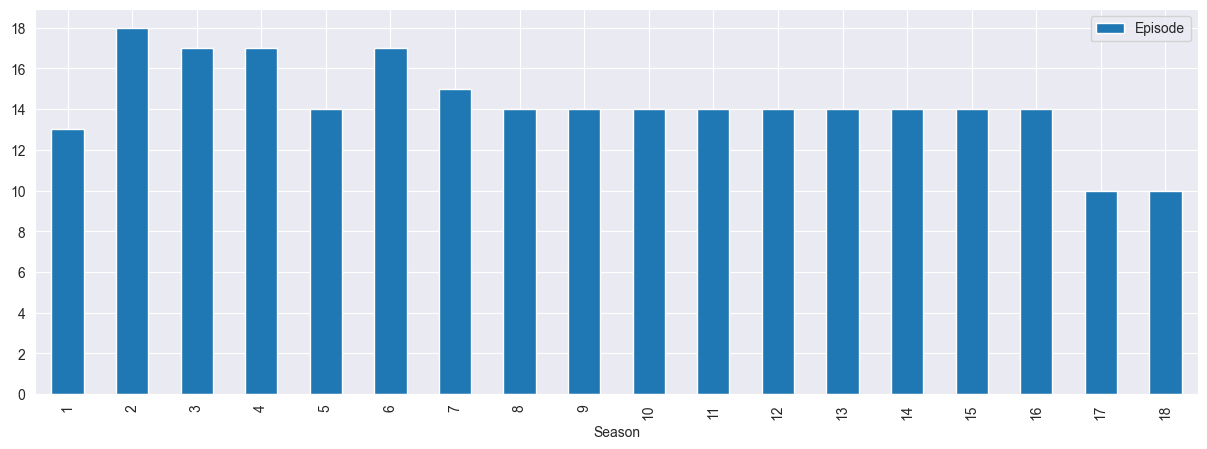

In [41]:
episodes_count = df.groupby("Season")["Episode"].nunique()
episodes_count = episodes_count.sort_index(key=lambda x: x.astype(int)).reset_index()

episodes_count.plot(kind="bar", x="Season", y="Episode", figsize=(15, 5))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

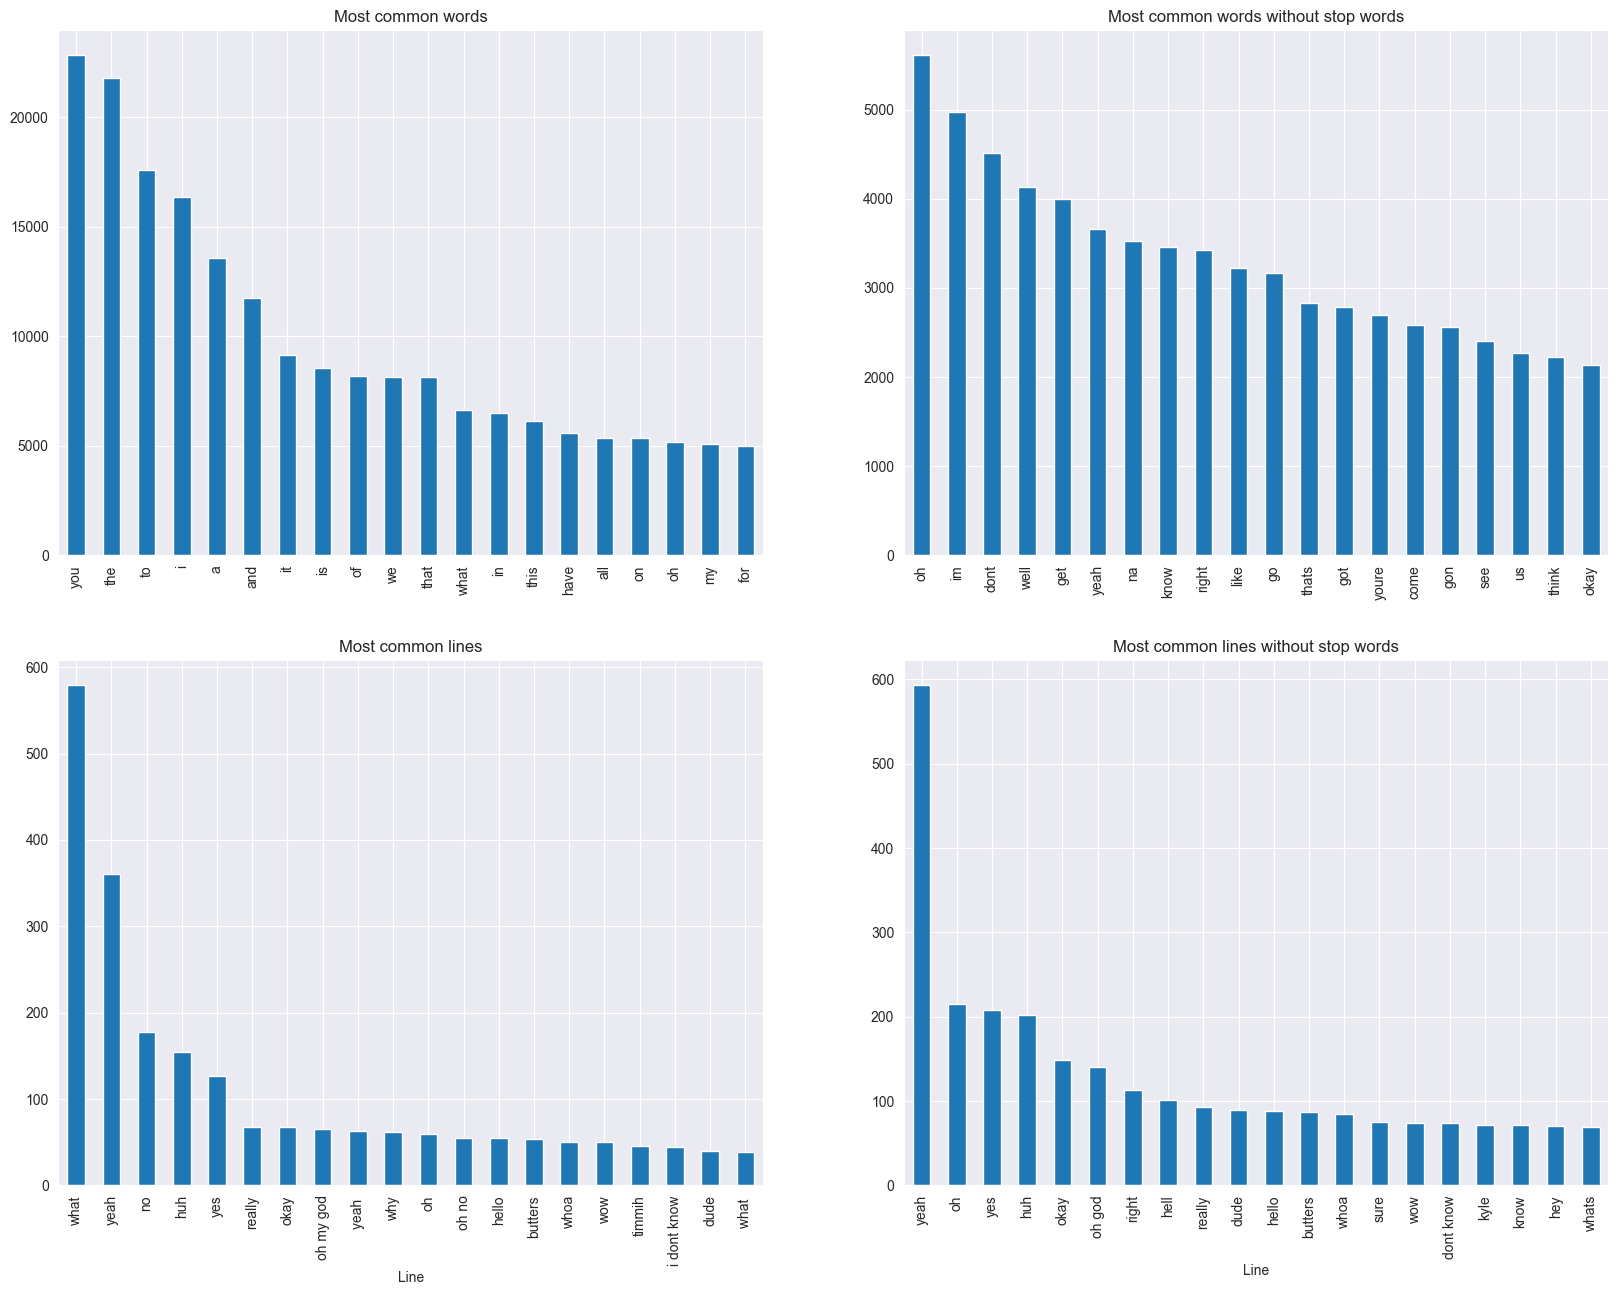

In [42]:
most_common_words = pd.Series(" ".join(df["Line"]).split()).value_counts()[:20]
most_common_words_no_stop = pd.Series(" ".join(df_no_stop["Line"]).split()).value_counts()[:20]
most_common_lines = df["Line"].value_counts()[:20]
most_common_lines_no_stop = df_no_stop["Line"].value_counts()[:20]

fig, axs = plt.subplots(2, 2, figsize=(20, 15))

most_common_words.plot(kind="bar", ax=axs[0, 0])
axs[0, 0].set_title("Most common words")

most_common_words_no_stop.plot(kind="bar", ax=axs[0, 1])
axs[0, 1].set_title("Most common words without stop words")

most_common_lines.plot(kind="bar", ax=axs[1, 0])
axs[1, 0].set_title("Most common lines")

most_common_lines_no_stop.plot(kind="bar", ax=axs[1, 1])
axs[1, 1].set_title("Most common lines without stop words")

plt.show()

The plot above shows the number of episodes in each season. The number of episodes in each season varies from 10 to 18.

The plot above shows the 20 most common words and lines in the dataset. The most common word is "oh" and the most common line is "yeah". 

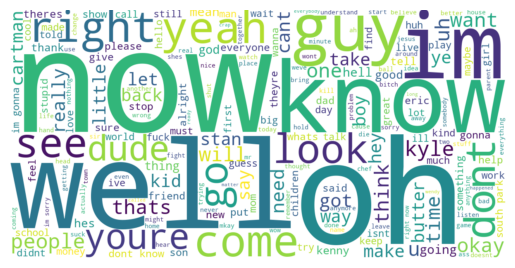

In [43]:
word_cloud = WordCloud(width=1200, height=600, background_color="white").generate(" ".join(df["Line"]))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")

plt.show()

The word cloud above highlights the various keywords present in the dataset. Larger words indicate more frequent occurrences, while smaller ones represent less common terms. This visualization helps identify dominant themes and trends within the data more precisely.

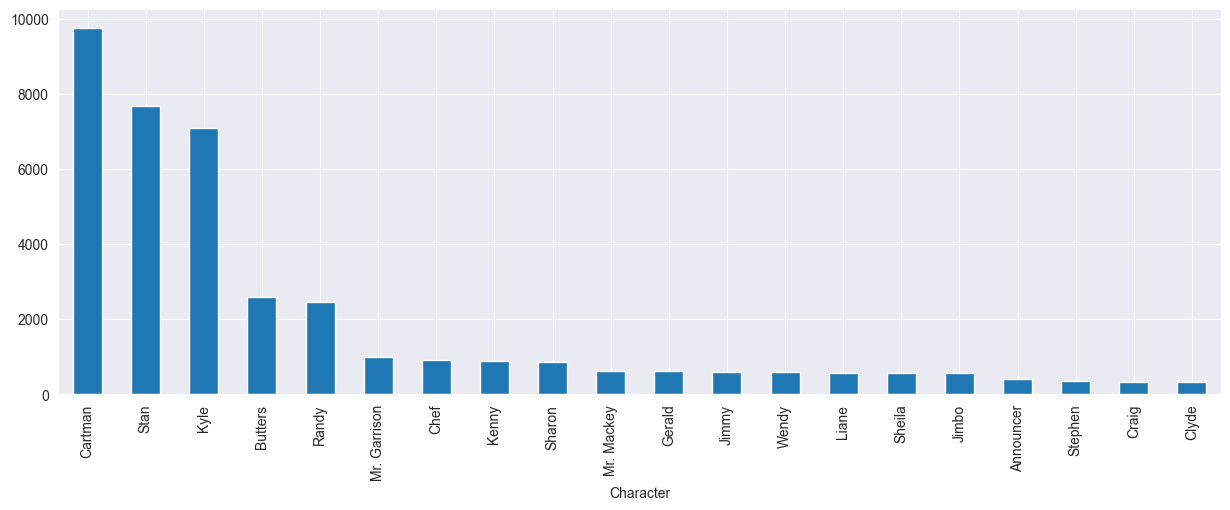

In [44]:
characters_count = df["Character"].value_counts()
least_common_characters = characters_count[characters_count == 10]
most_common_characters = characters_count[:20]

most_common_characters.plot(kind="bar", figsize=(15, 5))

plt.show()

The plot above shows the 20 most common characters in the dataset. The most common characters are "Cartman", "Stan" and "Kyle" as they are the main characters in show.

In [45]:
least_common_characters = characters_count[characters_count == 10]
least_common_characters

Character
Gabriel          10
Foreman          10
Evil Stan        10
Mall Hankey      10
Chief Stevens    10
                 ..
Owner            10
Butt Out!        10
Kevin Harris     10
Porsche          10
OC Member 1      10
Name: count, Length: 77, dtype: int64

The characters with the least dialogues are shown above. There are 62 characters with 10 dialogues which is the least that a character can have that are allowed in the dataset.

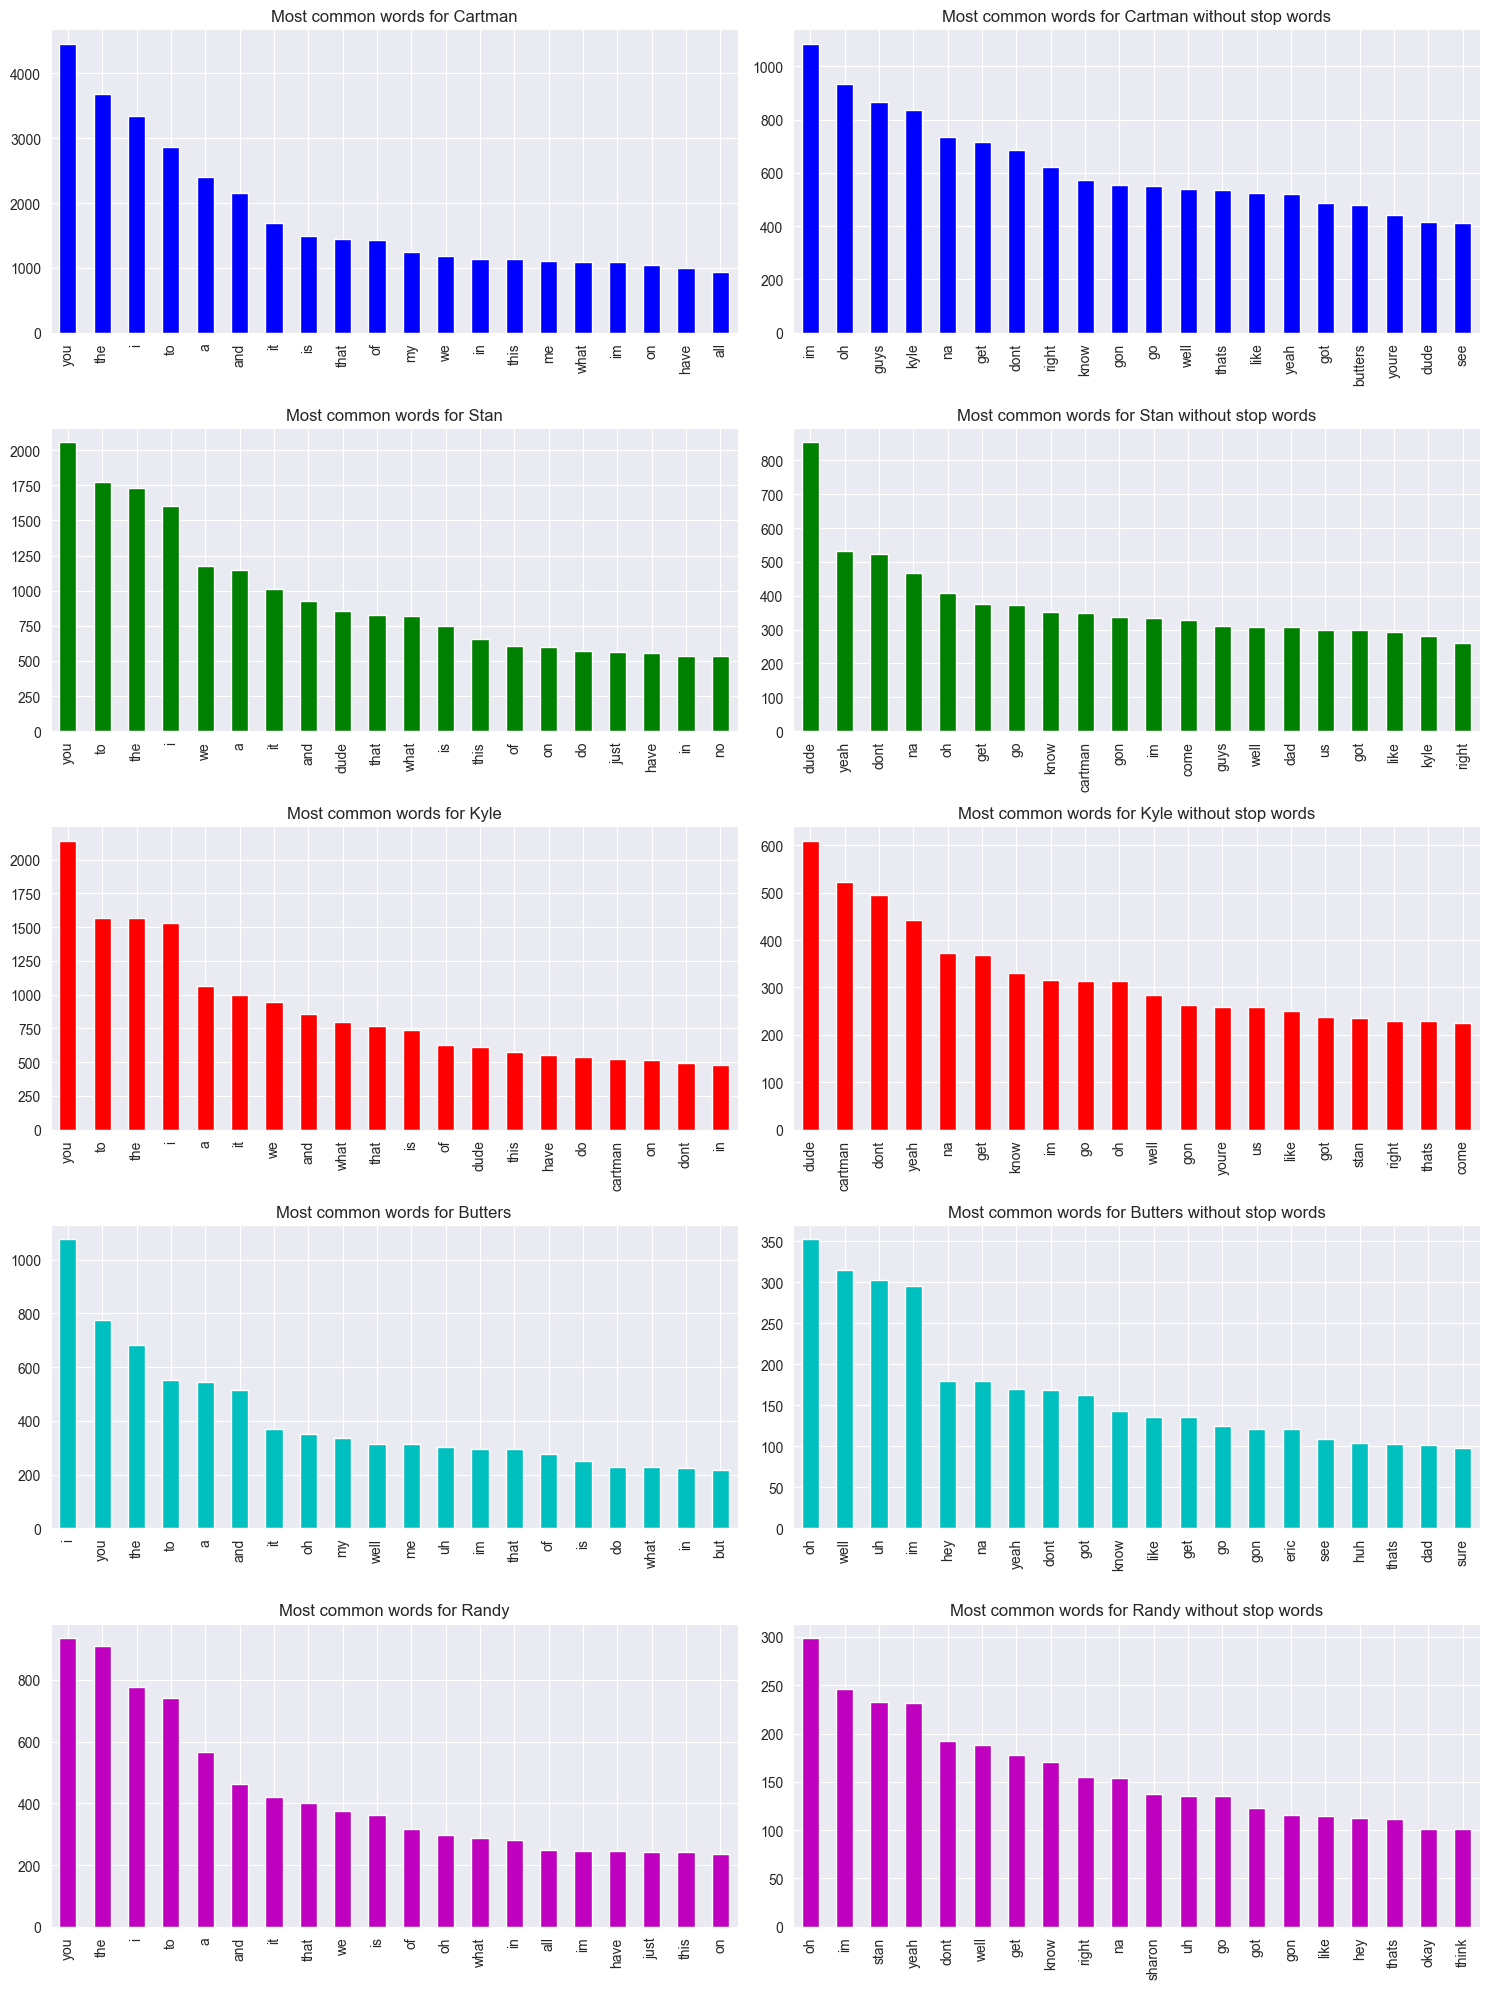

In [46]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Arrays to store the most common words for each character
most_common_words_per_character = []
most_common_words_no_stop_per_character = []

most_common_characters = characters_count[:5].index
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, character in enumerate(most_common_characters):
    character_lines = df[df["Character"] == character]["Line"]
    character_lines_no_stop = df_no_stop[df_no_stop["Character"] == character]["Line"]
    most_common_words = pd.Series(" ".join(character_lines).split()).value_counts()[:20]
    most_common_words_no_stop = pd.Series(" ".join(character_lines_no_stop).split()).value_counts()[:20]

    # Add the most common words to the arrays
    most_common_words_per_character.append({
        "character": character,
        "most_common_words": most_common_words.to_dict()
    })
    most_common_words_no_stop_per_character.append({
        "character": character,
        "most_common_words_no_stop": most_common_words_no_stop.to_dict()
    })

    most_common_words.plot(kind="bar", ax=axs[i, 0], color=colors[i % len(colors)])
    most_common_words_no_stop.plot(kind="bar", ax=axs[i, 1], color=colors[i % len(colors)])
    axs[i, 0].set_title(f"Most common words for {character}")
    axs[i, 1].set_title(f"Most common words for {character} without stop words")

plt.tight_layout()
plt.show()

The plot above shows the 20 most common words for the 5 most common characters in the dataset. The most common words for each character are different and unique to the character. We can see that there are many duplicate words in the dataset with stop words that are not useful in distinguishing the characters.

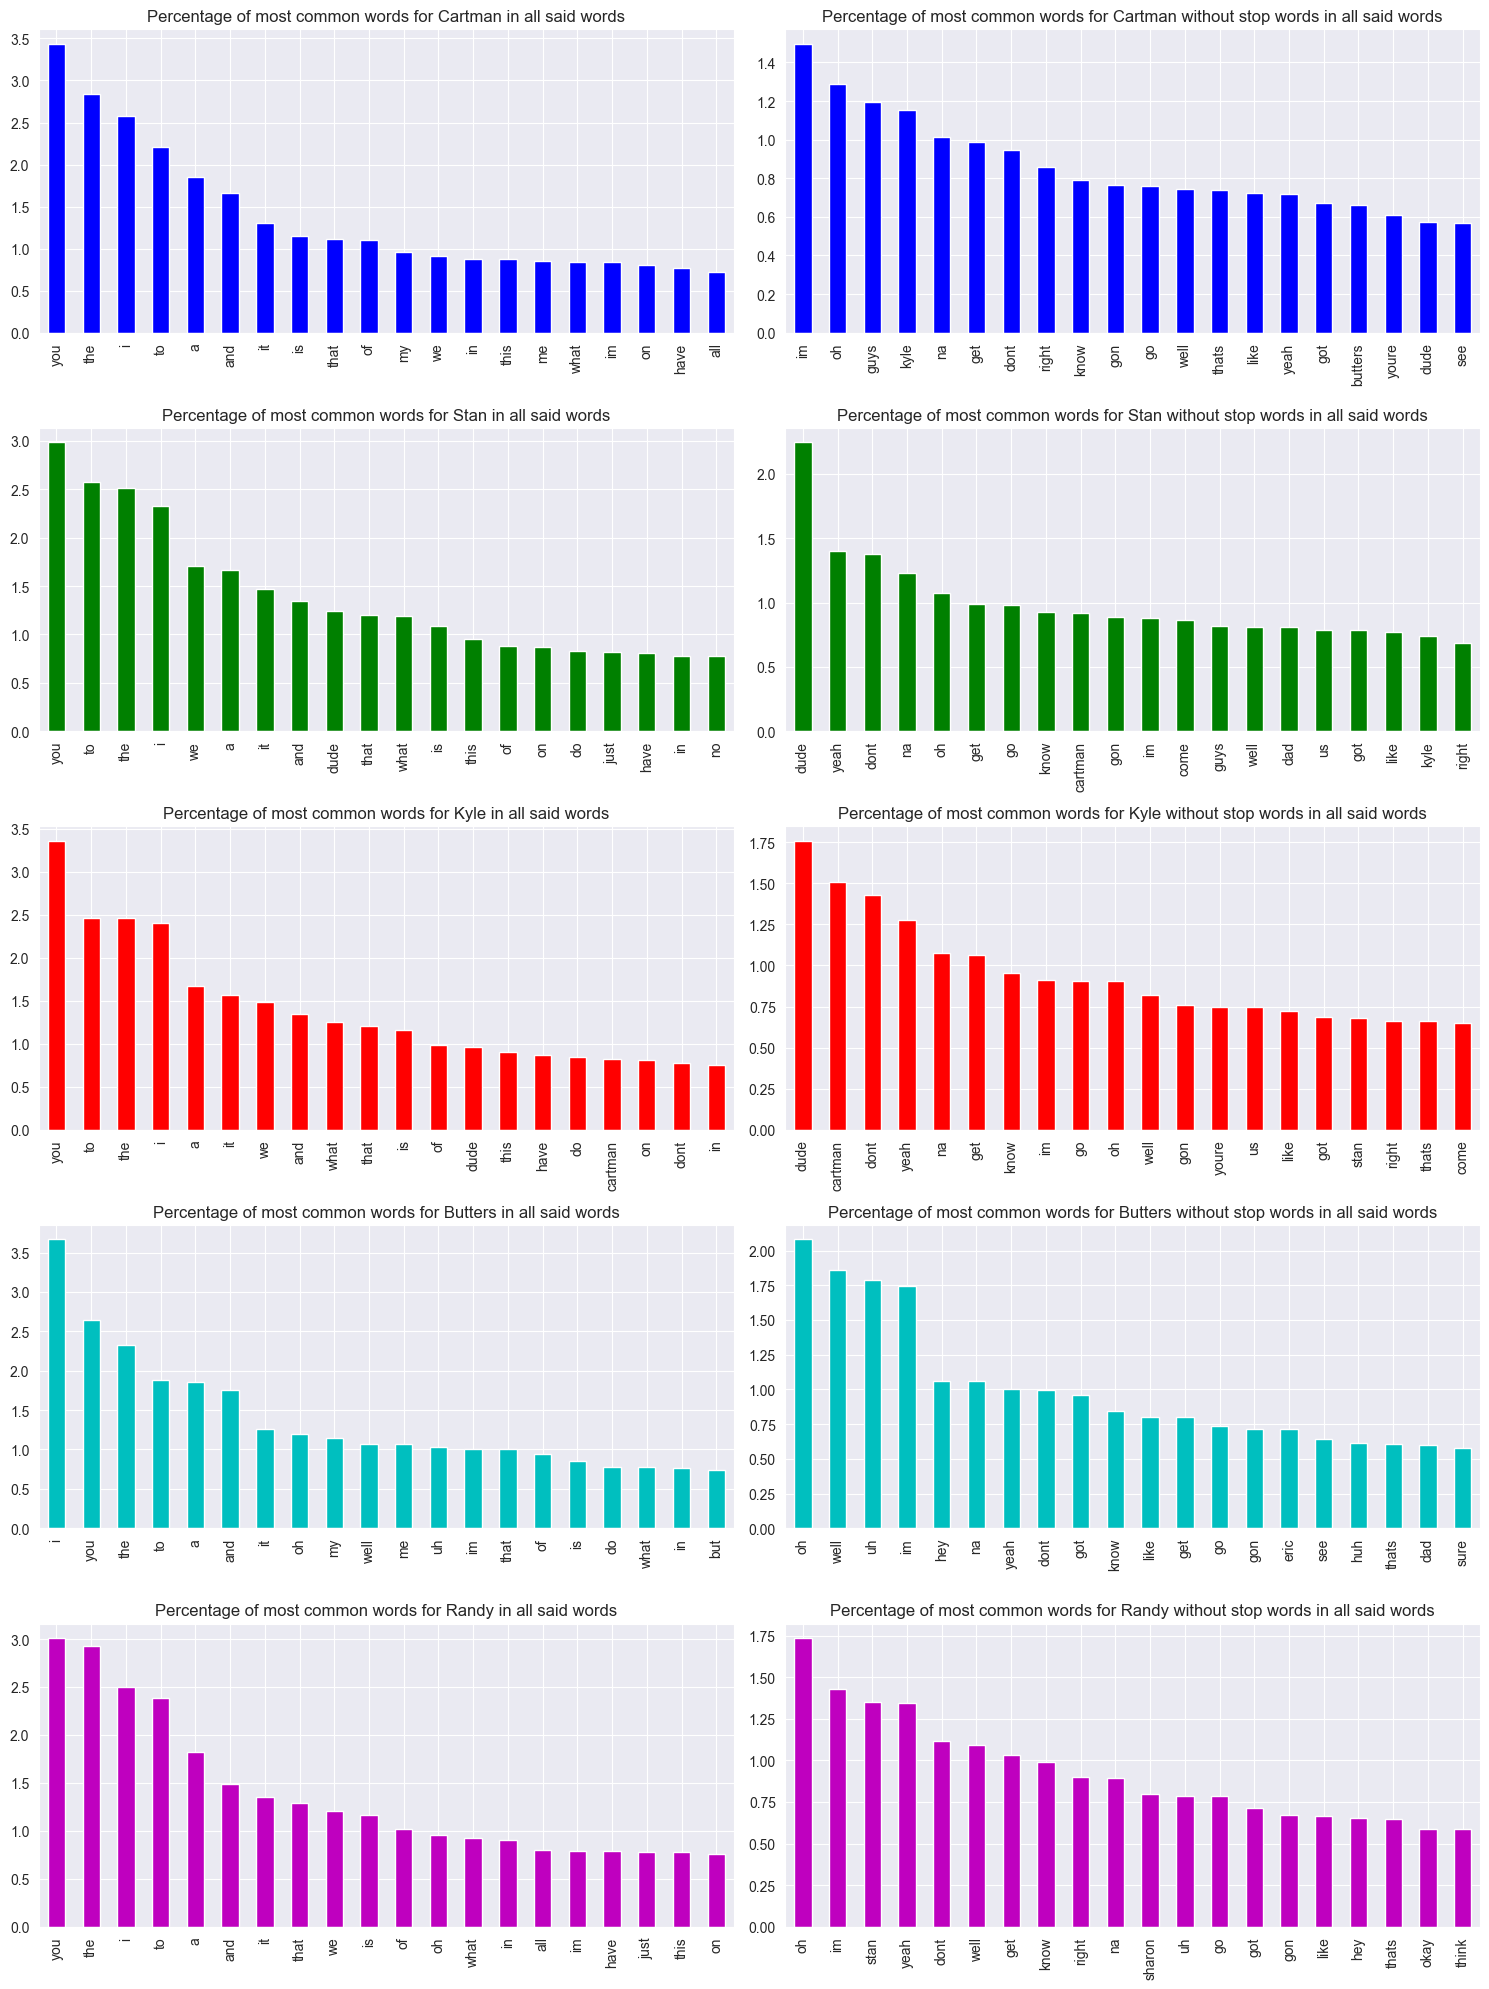

In [51]:
#Display the result
most_common_words_per_character_percentage = []
most_common_words_no_stop_per_character_percentage = []

fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, character in enumerate(most_common_characters):
    character_lines = df[df["Character"] == character]["Line"]
    character_lines_no_stop = df_no_stop[df_no_stop["Character"] == character]["Line"]
    total_words = len(" ".join(character_lines).split())
    total_words_no_stop = len(" ".join(character_lines_no_stop).split())

    most_common_words = pd.Series(" ".join(character_lines).split()).value_counts()[:20]
    most_common_words_no_stop = pd.Series(" ".join(character_lines_no_stop).split()).value_counts()[:20]

    most_common_words_percentage = most_common_words / total_words * 100
    most_common_words_no_stop_percentage = most_common_words_no_stop / total_words_no_stop * 100

    # Add the most common words to the arrays
    most_common_words_per_character_percentage.append({
        "character": character,
        "most_common_words": most_common_words_percentage.to_dict()
    })
    most_common_words_no_stop_per_character_percentage.append({
        "character": character,
        "most_common_words_no_stop": most_common_words_no_stop_percentage.to_dict()
    })

    most_common_words_percentage.plot(kind="bar", ax=axs[i, 0], color=colors[i % len(colors)])
    most_common_words_no_stop_percentage.plot(kind="bar", ax=axs[i, 1], color=colors[i % len(colors)])
    axs[i, 0].set_title(f"Percentage of most common words for {character} in all said words")
    axs[i, 1].set_title(f"Percentage of most common words for {character} without stop words in all said words")

plt.tight_layout()
plt.show()